In [1]:
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim
from torch.optim import Adam

from torchvision import transforms, datasets
from torch.utils.data import DataLoader, random_split

import copy


### Set Hyperparameters

In [2]:
image_size=(150,150)
input_shape = (150, 150, 3)
num_classes = 6
batch_size=64
epochs = 100
patience = 15
train_data_path="/kaggle/input/intel-image-classification/seg_train/seg_train"
test_data_path="/kaggle/input/intel-image-classification/seg_test/seg_test"

### Data Augmentation

In [3]:
# -----------------------------
# Training data augmentations
# -----------------------------
train_transform = transforms.Compose([
    transforms.Resize(image_size),                       # Resize first
    transforms.RandomHorizontalFlip(p=0.5),             # Horizontal flip
    transforms.RandomVerticalFlip(p=0.5),               # Vertical flip
    transforms.RandomRotation(degrees=30),              # ±30 degrees rotation
    transforms.RandomResizedCrop(                        # Zoom in/out like RandomZoom
        size=image_size,
        scale=(0.8, 1.2),                               # Zoom factor ±20%
        ratio=(1.0, 1.0)                                # Keep aspect ratio
    ),
    transforms.ColorJitter(
        brightness=0.2,                                 # RandomBrightness
        contrast=0.2                                    # RandomContrast
    ),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],    # Standard ImageNet normalization
                         std=[0.229, 0.224, 0.225])
])

# -----------------------------
# Validation & Test transformations
# -----------------------------
val_transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Test transform is same as validation
test_transform = val_transform

### Load Training data and train-val split

In [4]:
# Set seed for reproducibility
seed = 42
generator = torch.Generator().manual_seed(seed)

full_train_dataset = datasets.ImageFolder(root=train_data_path, transform=train_transform)

# Train/validation split
val_size = int(0.2 * len(full_train_dataset))
train_size = len(full_train_dataset) - val_size
train_ds, val_ds = random_split(full_train_dataset, [train_size, val_size], generator=generator)

# Assign respective transforms explicitly
train_ds.dataset.transform = train_transform
val_ds.dataset.transform = val_transform

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False, num_workers=4)

print(f"Number of training samples: {len(train_ds)}")
print(f"Number of validation samples: {len(val_ds)}")

Number of training samples: 11228
Number of validation samples: 2806


## Load Test data

In [5]:
test_ds = datasets.ImageFolder(root=test_data_path, transform=test_transform)
test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False, num_workers=4)

print(f"Number of testing samples: {len(test_ds)}")

Number of testing samples: 3000


### Get Class Names

In [6]:
class_names = train_ds.dataset.classes  # train_ds comes from random_split
print(class_names)

['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']


### Visualise sample data

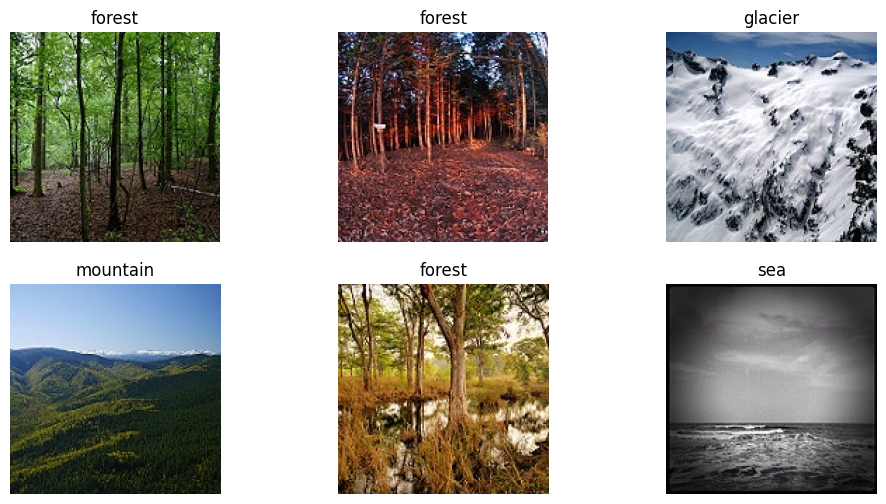

In [7]:

#sample_loader = train_loader
sample_loader = val_loader
#sample_loader = test_loader

# Get one batch
images, labels = next(iter(sample_loader))

# Un-normalize images for visualization
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

images_np = images.permute(0, 2, 3, 1).numpy()  # Convert to HWC
images_np = std * images_np + mean               # Un-normalize
images_np = np.clip(images_np, 0, 1)            # Clip values to [0,1]

plt.figure(figsize=(12, 6))
for i in range(6):
    ax = plt.subplot(2, 3, i + 1)
    plt.imshow(images_np[i])
    plt.title(class_names[labels[i].item()])
    plt.axis("off")
plt.show()


### Model Architecture

In [8]:

class CNNModel(nn.Module):
    def __init__(self, num_classes=6):
        super(CNNModel, self).__init__()
        
        # -----------------------
        # 1st Conv block
        # -----------------------
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),  # input 3 channels (RGB)
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # -----------------------
        # 2nd Conv block
        # -----------------------
        self.conv2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # -----------------------
        # 3rd Conv block
        # -----------------------
        self.conv3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # -----------------------
        # 4th Conv block
        # -----------------------
        self.conv4 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # -----------------------
        # Fully connected layers
        # -----------------------
        # Note: need to compute flatten size dynamically or use AdaptiveAvgPool2d
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(512 * 9 * 9, 512)  # assuming input 150x150 -> 9x9 after 4 MaxPool(2)
        self.dropout1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(512, 512)
        self.dropout2 = nn.Dropout(0.5)
        self.out = nn.Linear(512, num_classes)

    def forward(self, x):
        # Conv blocks
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)

        # Flatten
        x = self.flatten(x)

        # Fully connected
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        x = F.relu(self.fc2(x))
        x = self.dropout2(x)
        x = self.out(x)  # logits

        return x  # use nn.CrossEntropyLoss which applies softmax internally


# Example: create model
model = CNNModel(num_classes=num_classes)
print(model)


CNNModel(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv4): Sequential(
    (0): C

### Model Training

In [9]:

# -------------------------------
# Device
# -------------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# -------------------------------
# Loss and optimizer
# -------------------------------
criterion = nn.CrossEntropyLoss()                # sparse_categorical_crossentropy equivalent
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# -------------------------------
# Early stopping parameters
# -------------------------------
patience = patience
best_val_acc = 0.0
best_model_wts = copy.deepcopy(model.state_dict())
epochs_no_improve = 0
num_epochs = epochs

# -------------------------------
# Training loop
# -------------------------------
history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}

for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    
    # ---- Training ----
    model.train()
    running_loss = 0.0
    running_corrects = 0
    total = 0

    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        running_corrects += torch.sum(preds == labels.data)
        total += labels.size(0)

    epoch_loss = running_loss / total
    epoch_acc = running_corrects.double() / total
    history["train_loss"].append(epoch_loss)
    history["train_acc"].append(epoch_acc.item())

    # ---- Validation ----
    model.eval()
    val_running_loss = 0.0
    val_running_corrects = 0
    val_total = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            val_running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            val_running_corrects += torch.sum(preds == labels.data)
            val_total += labels.size(0)

    val_loss = val_running_loss / val_total
    val_acc = val_running_corrects.double() / val_total
    history["val_loss"].append(val_loss)
    history["val_acc"].append(val_acc.item())

    print(f"train_loss: {epoch_loss:.4f}, train_acc: {epoch_acc:.4f} | val_loss: {val_loss:.4f}, val_acc: {val_acc:.4f}")

    # ---- Early stopping & checkpoint ----
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_model_wts = copy.deepcopy(model.state_dict())
        epochs_no_improve = 0
        torch.save(model.state_dict(), "/kaggle/working/best_model.pth")
        print("** Validation accuracy improved. Model saved. **")
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print(f"Early stopping triggered after {patience} epochs with no improvement.")
            break

# Load best model weights
model.load_state_dict(best_model_wts)


Epoch 1/100
train_loss: 1.3131, train_acc: 0.4578 | val_loss: 1.0210, val_acc: 0.5823
** Validation accuracy improved. Model saved. **
Epoch 2/100
train_loss: 0.9990, train_acc: 0.5966 | val_loss: 0.9066, val_acc: 0.6233
** Validation accuracy improved. Model saved. **
Epoch 3/100
train_loss: 0.8762, train_acc: 0.6524 | val_loss: 0.7841, val_acc: 0.6871
** Validation accuracy improved. Model saved. **
Epoch 4/100
train_loss: 0.7983, train_acc: 0.6854 | val_loss: 0.6919, val_acc: 0.7299
** Validation accuracy improved. Model saved. **
Epoch 5/100
train_loss: 0.7119, train_acc: 0.7332 | val_loss: 0.6490, val_acc: 0.7666
** Validation accuracy improved. Model saved. **
Epoch 6/100
train_loss: 0.6164, train_acc: 0.7753 | val_loss: 0.5259, val_acc: 0.8097
** Validation accuracy improved. Model saved. **
Epoch 7/100
train_loss: 0.5414, train_acc: 0.8092 | val_loss: 0.4966, val_acc: 0.8247
** Validation accuracy improved. Model saved. **
Epoch 8/100
train_loss: 0.4968, train_acc: 0.8277 | val

<All keys matched successfully>

### Accuracy and Loss Plots

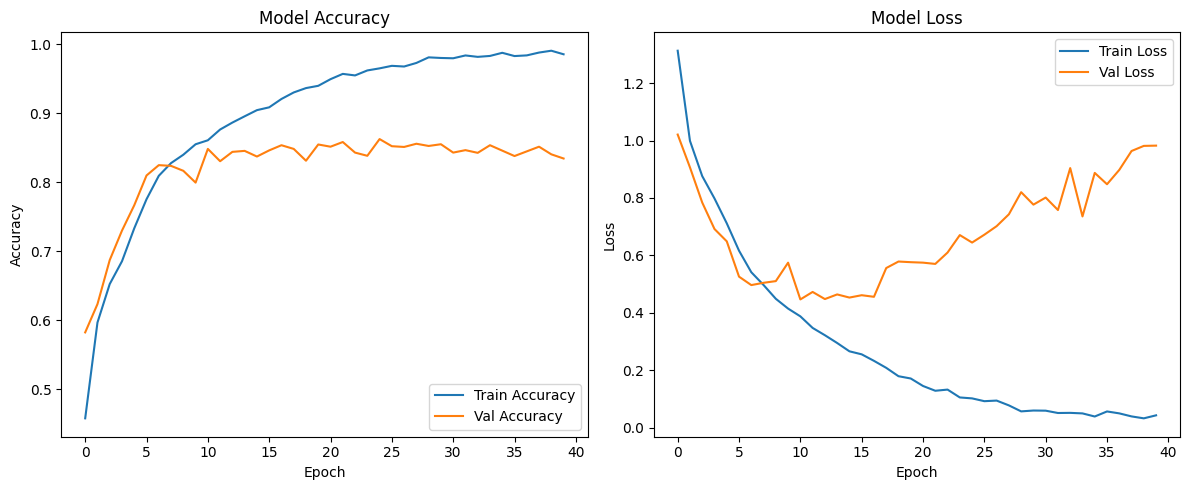

In [10]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy and loss
plt.figure(figsize=(12, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history['train_acc'], label='Train Accuracy')
plt.plot(history['val_acc'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

# Loss
plt.subplot(1, 2, 2)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()


### Model Evaluation on Train, Val, Test sets

In [11]:
import torch
import torch.nn as nn

# -------------------------------
# 1. Load the trained model
# -------------------------------
model = CNNModel(num_classes=num_classes)  # same architecture
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Load saved weights
model.load_state_dict(torch.load("/kaggle/working/best_model.pth", map_location=device))
model.eval()
print("Trained model loaded successfully!")

# -------------------------------
# 2. Define criterion (same as training)
# -------------------------------
criterion = nn.CrossEntropyLoss()

# -------------------------------
# 3. Evaluation function
# -------------------------------
def evaluate_model(model, data_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            running_corrects += torch.sum(preds == labels.data)
            total += labels.size(0)

    epoch_loss = running_loss / total
    epoch_acc = running_corrects.double() / total
    return epoch_loss, epoch_acc.item()

# -------------------------------
# 4. Evaluate on train, val, test sets
# -------------------------------
train_loss, train_acc = evaluate_model(model, train_loader, criterion, device)
val_loss, val_acc = evaluate_model(model, val_loader, criterion, device)
test_loss, test_acc = evaluate_model(model, test_loader, criterion, device)

# -------------------------------
# 5. Print results
# -------------------------------
print("=========================================")
print(f"Train Accuracy: {train_acc:.4f}")
print(f"Val Accuracy: {val_acc:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")
print("=========================================")
print(f"Train Loss: {train_loss:.4f}")
print(f"Val Loss: {val_loss:.4f}")
print(f"Test Loss: {test_loss:.4f}")


Trained model loaded successfully!
Train Accuracy: 0.9903
Val Accuracy: 0.8624
Test Accuracy: 0.8473
Train Loss: 0.0363
Val Loss: 0.6447
Test Loss: 0.6950


### Confusion Matrix on test set

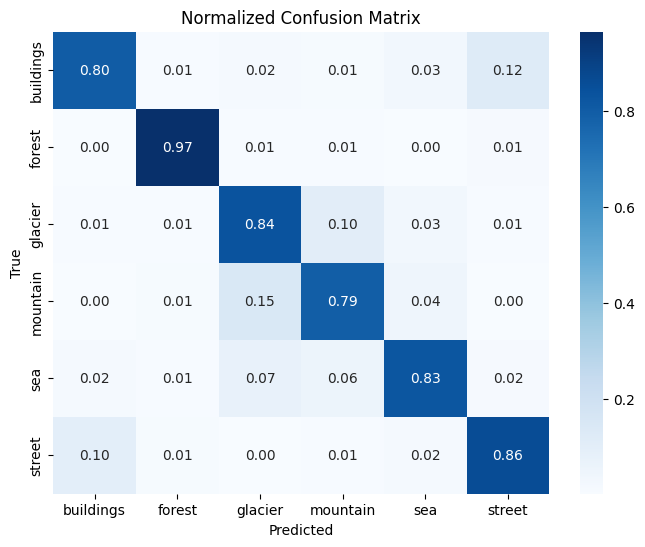

              precision    recall  f1-score   support

   buildings       0.84      0.80      0.82       437
      forest       0.95      0.97      0.96       474
     glacier       0.78      0.84      0.81       553
    mountain       0.81      0.79      0.80       525
         sea       0.86      0.83      0.84       510
      street       0.85      0.86      0.86       501

    accuracy                           0.85      3000
   macro avg       0.85      0.85      0.85      3000
weighted avg       0.85      0.85      0.85      3000



In [13]:
import torch
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# -------------------------------
# Initialize lists
# -------------------------------
y_true = []
y_pred = []

# -------------------------------
# Iterate over test loader
# -------------------------------
model.eval()
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

# Convert to numpy arrays
y_true = np.array(y_true)
y_pred = np.array(y_pred)

# -------------------------------
# Confusion matrix
# -------------------------------
cm = confusion_matrix(y_true, y_pred)
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Class names
class_names = test_ds.classes  # PyTorch equivalent of test_ds.class_names

# Plot normalized confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_norm, annot=True, fmt=".2f", cmap="Blues",
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Normalized Confusion Matrix")
plt.show()

# -------------------------------
# Classification report
# -------------------------------
print(classification_report(y_true, y_pred, target_names=class_names))


### Prediction on Unseen data

Predicted class: forest


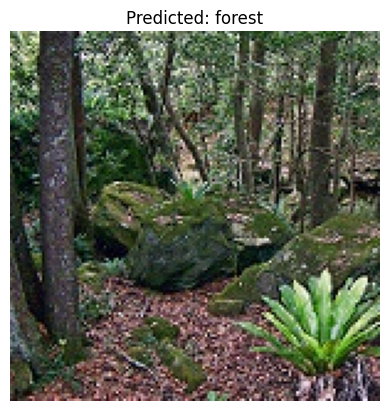

In [18]:
import torch
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

# -------------------------------
# 1. Load trained model
# -------------------------------
model = CNNModel(num_classes=num_classes)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.load_state_dict(torch.load("/kaggle/working/best_model.pth", map_location=device))
model = model.to(device)
model.eval()

# -------------------------------
# 2. Class names (same as training)
# -------------------------------
class_names = ["buildings", "forest", "glacier", "mountain", "sea", "street"]

# -------------------------------
# 3. Load and preprocess image
# -------------------------------
img_path = "/kaggle/input/intel-image-classification/seg_pred/seg_pred/10092.jpg"
img = Image.open(img_path).convert("RGB")  # ensure 3 channels

# Define same transforms as training
preprocess = transforms.Compose([
    transforms.Resize((150, 150)),       # match training image size
    transforms.ToTensor(),               # convert to tensor [0,1]
    transforms.Normalize(                # normalize with same mean/std as training
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

img_tensor = preprocess(img).unsqueeze(0).to(device)  # add batch dimension

# -------------------------------
# 4. Predict
# -------------------------------
with torch.no_grad():
    outputs = model(img_tensor)
    _, pred_class = torch.max(outputs, 1)
    class_name = class_names[pred_class.item()]

print(f"Predicted class: {class_name}")

# -------------------------------
# 5. Display image
# -------------------------------
plt.imshow(img)
plt.axis('off')
plt.title(f"Predicted: {class_name}")
plt.show()


### Pytorch to Onnx Conversion

In [19]:
import torch

pytorch_model_path="/kaggle/working/best_model.pth"
onnx_model_path="/kaggle/working/best_model.onnx"

# -------------------------------
# 1. Load trained PyTorch model
# -------------------------------
model = CNNModel(num_classes=num_classes)
model.load_state_dict(torch.load(pytorch_model_path, map_location='cpu'))
model.eval()

# -------------------------------
# 2. Define dummy input
# -------------------------------
dummy_input = torch.randn(1, 3, 150, 150)  # batch=1, 3 channels, 150x150

# -------------------------------
# 3. Export to ONNX
# -------------------------------
onnx_model_path = onnx_model_path
torch.onnx.export(
    model, 
    dummy_input, 
    onnx_model_path, 
    export_params=True,          # store trained parameters
    opset_version=13,            # ONNX opset version
    do_constant_folding=True,    # fold constants for optimization
    input_names=['input'],       # model input name
    output_names=['output'],     # model output name
    dynamic_axes={'input': {0: 'batch_size'}, 'output': {0: 'batch_size'}}  # variable batch size
)

print(f"Model successfully exported to {onnx_model_path}")


Model successfully exported to /kaggle/working/best_model.onnx
